# Feature Engineering

In [37]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. Load Raw Data

In [38]:
# Load dataset
DATA_PATH = Path("../data/raw/Churn_Modelling.csv")
PROCESSED_PATH = Path("../data/processed")
PROCESSED_PATH.mkdir(parents=True, exist_ok=True)

if DATA_PATH.exists():
    df = pd.read_csv(DATA_PATH, index_col='RowNumber')
    print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    print(f"Data not found")

df.head()

Data loaded: 10000 rows, 13 columns


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [39]:
# Define feature groups
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender']
binary_cols = ['HasCrCard', 'IsActiveMember']
id_cols = ['CustomerId', 'Surname']
target = 'Exited'

## 2. Feature Engineering

| Feature | Formula | Business Logic |
|---------|---------|----------------|
| `balance_salary_ratio` | Balance / Salary | Financial health indicator |
| `products_per_tenure` | Products / Tenure | Product adoption rate |
| `age_group` | Binned Age | Customer lifecycle stage |
| `wealth_score` | Balance × CreditScore | Combined wealth metric |
| `engagement_score` | HasCrCard + IsActive + (Products > 1) | Activity level |
| `tenure_age_ratio` | Tenure / Age | Loyalty relative to age |
| `is_high_balance` | Balance > median | Binary wealth flag |
| `credit_risk_tier` | Binned CreditScore | Risk categorization |
| `is_germany` | Geography == 'Germany' | High-risk geography flag |
| `is_senior` | Age >= 50 | Senior customer flag |
| `zero_balance` | Balance == 0 | Disengagement indicator |

In [40]:
def engineer_features(df):
    """Create engineered features for bank churn prediction."""
    df = df.copy()
    
    # RATIO FEATURES (Financial Health Indicators)
    
    df['balance_salary_ratio'] = df['Balance'] / (df['EstimatedSalary'] + 1)
    df['products_per_tenure'] = df['NumOfProducts'] / (df['Tenure'] + 1)
    df['tenure_age_ratio'] = df['Tenure'] / (df['Age'] + 1)
    df['credit_age_ratio'] = df['CreditScore'] / (df['Age'] + 1)
    
    # COMPOSITE SCORES
    
    df['wealth_score'] = (df['Balance'] * df['CreditScore']) / 100000
    df['engagement_score'] = (
        df['HasCrCard'] + 
        df['IsActiveMember'] + 
        (df['NumOfProducts'] > 1).astype(int)
    )
    df['stability_score'] = (
        (df['CreditScore'] / 850) * 0.4 +  # Normalized credit score
        (df['Tenure'] / 10) * 0.3 +          # Normalized tenure
        df['IsActiveMember'] * 0.3            # Activity
    )
    
    # BINNED FEATURES (Categorical from Numerical)
    
    df['age_group'] = pd.cut(
        df['Age'],
        bins=[0, 30, 40, 50, 60, 100],
        labels=['young', 'adult', 'middle', 'senior', 'elderly']
    ).astype(str)
    df['credit_tier'] = pd.cut(
        df['CreditScore'],
        bins=[0, 580, 670, 740, 800, 900],
        labels=['poor', 'fair', 'good', 'very_good', 'excellent']
    ).astype(str)
    balance_median = df['Balance'].median()
    df['balance_tier'] = pd.cut(
        df['Balance'],
        bins=[-1, 0, balance_median, balance_median * 2, float('inf')],
        labels=['zero', 'low', 'medium', 'high']
    ).astype(str)
    df['tenure_group'] = pd.cut(
        df['Tenure'],
        bins=[-1, 2, 5, 8, 11],
        labels=['new', 'developing', 'established', 'loyal']
    ).astype(str)
    
    # BINARY FLAGS (Risk Indicators)
    
    df['is_high_balance'] = (df['Balance'] > df['Balance'].median()).astype(int)
    df['is_zero_balance'] = (df['Balance'] == 0).astype(int)
    df['is_senior'] = (df['Age'] >= 50).astype(int)
    df['is_new_customer'] = (df['Tenure'] <= 2).astype(int)
    df['is_germany'] = (df['Geography'] == 'Germany').astype(int)
    df['is_single_product'] = (df['NumOfProducts'] == 1).astype(int)
    df['is_multi_product'] = (df['NumOfProducts'] > 2).astype(int)
    df['is_low_credit'] = (df['CreditScore'] < 600).astype(int)
    
    # INTERACTION FEATURES
    
    df['senior_inactive'] = df['is_senior'] * (1 - df['IsActiveMember'])
    df['germany_inactive'] = df['is_germany'] * (1 - df['IsActiveMember'])
    df['zero_balance_inactive'] = df['is_zero_balance'] * (1 - df['IsActiveMember'])
    df['new_single_product'] = df['is_new_customer'] * df['is_single_product']
    
    return df

# Apply feature engineering
df_engineered = engineer_features(df)

# Show new features
new_features = [col for col in df_engineered.columns if col not in df.columns]
print(f"Created {len(new_features)} new features:")
print("=" * 50)
for i, feat in enumerate(new_features, 1):
    print(f"   {i:2d}. {feat}")
print("=" * 50)
print(f"\nTotal features: {df_engineered.shape[1]} columns")

Created 23 new features:
    1. balance_salary_ratio
    2. products_per_tenure
    3. tenure_age_ratio
    4. credit_age_ratio
    5. wealth_score
    6. engagement_score
    7. stability_score
    8. age_group
    9. credit_tier
   10. balance_tier
   11. tenure_group
   12. is_high_balance
   13. is_zero_balance
   14. is_senior
   15. is_new_customer
   16. is_germany
   17. is_single_product
   18. is_multi_product
   19. is_low_credit
   20. senior_inactive
   21. germany_inactive
   22. zero_balance_inactive
   23. new_single_product

Total features: 36 columns


In [41]:
# Preview engineered features
df_engineered.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_ratio,products_per_tenure,tenure_age_ratio,credit_age_ratio,wealth_score,engagement_score,stability_score,age_group,credit_tier,balance_tier,tenure_group,is_high_balance,is_zero_balance,is_senior,is_new_customer,is_germany,is_single_product,is_multi_product,is_low_credit,senior_inactive,germany_inactive,zero_balance_inactive,new_single_product
RowNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.333333,0.046512,14.395349,0.000000,2,0.651294,middle,fair,zero,new,0,1,0,1,0,1,0,0,0,0,0,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744670,0.500000,0.023810,14.476190,509.551789,1,0.616118,middle,fair,low,new,0,0,0,1,0,1,0,0,0,0,0,1
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401362,0.333333,0.186047,11.674419,801.497216,2,0.476235,middle,poor,medium,established,1,0,0,0,0,0,1,1,0,0,0,0
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,1.000000,0.025000,17.475000,0.000000,1,0.358941,adult,good,zero,new,0,1,0,1,0,0,0,0,0,0,1,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587035,0.333333,0.045455,19.318182,1066.841970,2,0.760000,middle,excellent,medium,new,1,0,0,1,0,1,0,0,0,0,0,1


In [42]:
# Check statistics of new numerical features
new_numerical = ['balance_salary_ratio', 'products_per_tenure', 'tenure_age_ratio', 
                 'credit_age_ratio', 'wealth_score', 'engagement_score', 'stability_score']

df_engineered[new_numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
balance_salary_ratio,10000.0,3.790150,100.055758,0.000000,0.000000,0.746998,1.514002,9770.883148
products_per_tenure,10000.0,0.367173,0.337760,0.090909,0.166667,0.250000,0.500000,3.000000
tenure_age_ratio,10000.0,0.134011,0.086429,0.000000,0.062500,0.125000,0.194444,0.526316
credit_age_ratio,10000.0,17.366444,5.108737,4.800000,13.769231,16.824265,20.333333,44.421053
wealth_score,10000.0,497.940741,417.276919,0.000000,0.000000,598.431372,828.303777,1808.614700
engagement_score,10000.0,1.712200,0.845602,0.000000,1.000000,2.000000,2.000000,3.000000
stability_score,10000.0,0.611045,0.178037,0.164706,0.461529,0.615941,0.759647,1.000000


## 3. Visualize Engineered Features

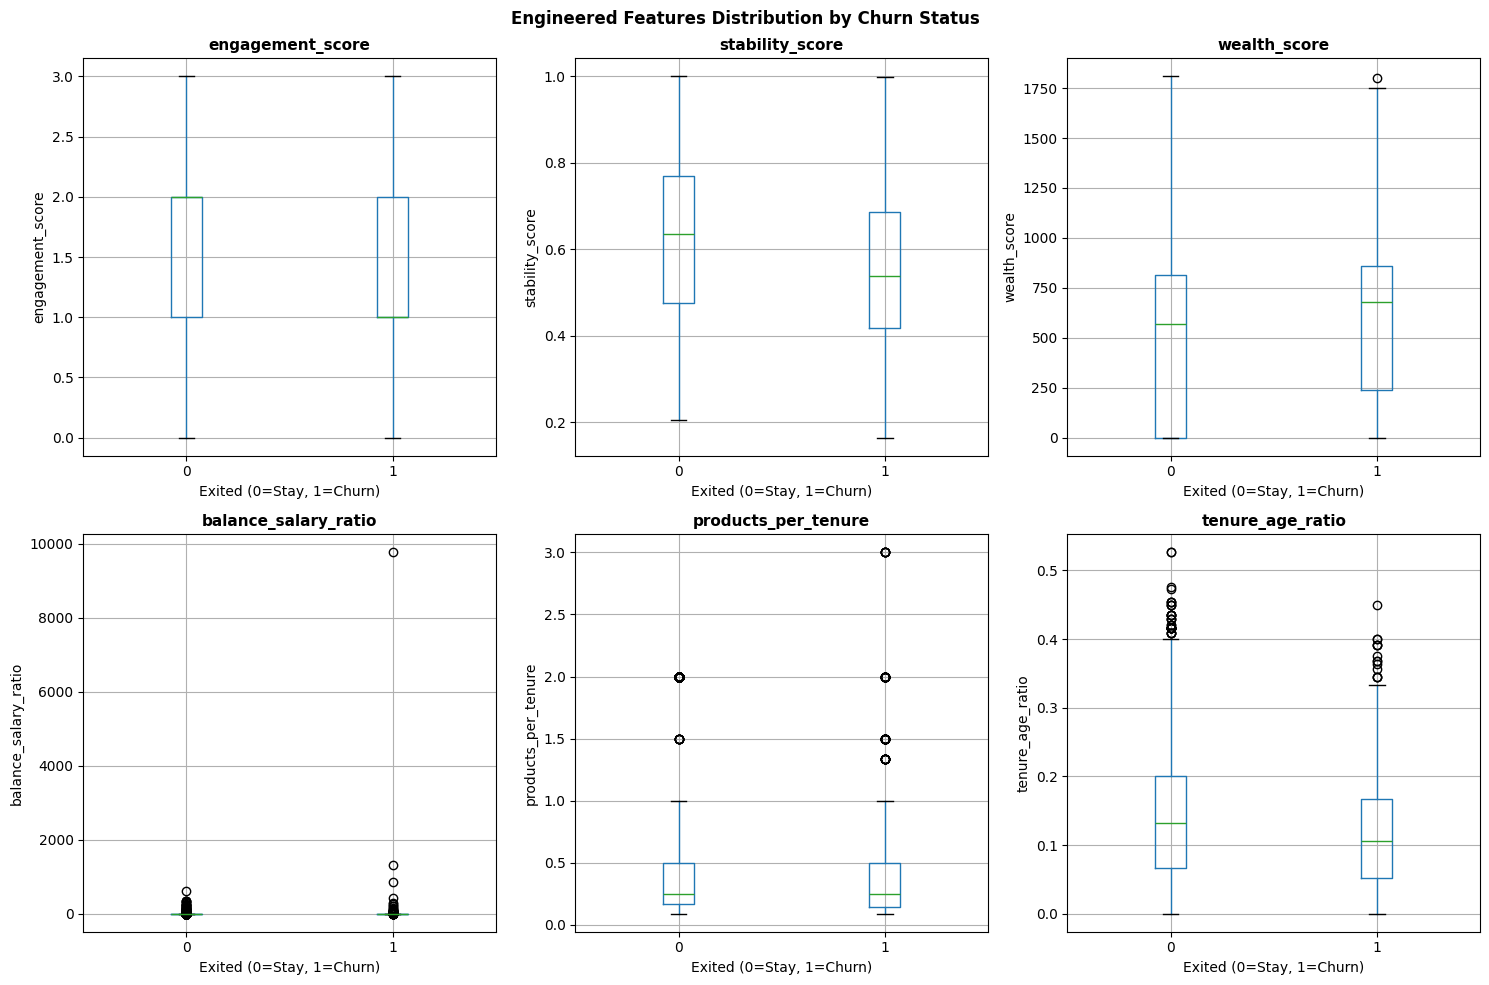

In [43]:
# Visualize new features vs target
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_features = ['engagement_score', 'stability_score', 'wealth_score', 
                 'balance_salary_ratio', 'products_per_tenure', 'tenure_age_ratio']

for idx, feat in enumerate(plot_features):
    ax = axes[idx]
    
    # Box plot by churn status
    df_engineered.boxplot(column=feat, by='Exited', ax=ax)
    ax.set_title(f'{feat}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Exited (0=Stay, 1=Churn)')
    ax.set_ylabel(feat)

plt.suptitle('Engineered Features Distribution by Churn Status', fontweight='bold')
plt.tight_layout()
plt.show()

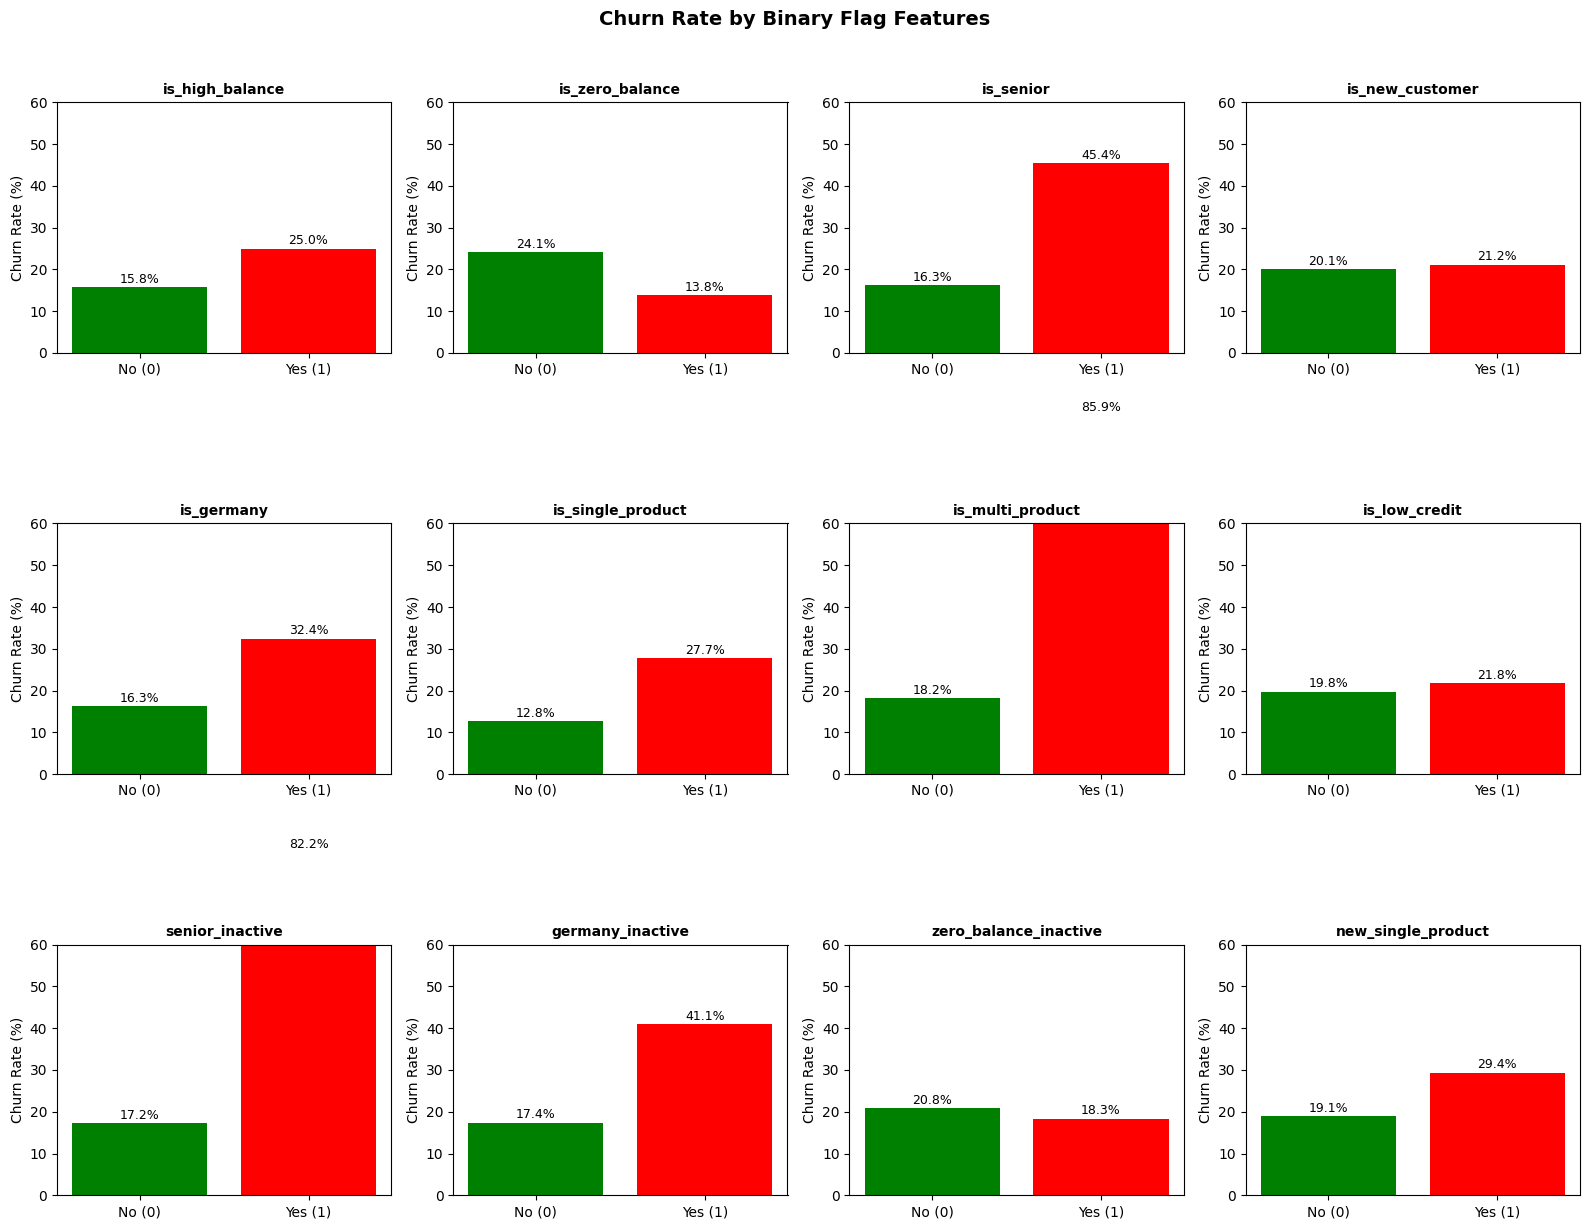

In [44]:
# Churn rate by binary flags
binary_flags = ['is_high_balance', 'is_zero_balance', 'is_senior', 'is_new_customer',
                'is_germany', 'is_single_product', 'is_multi_product', 'is_low_credit',
                'senior_inactive', 'germany_inactive', 'zero_balance_inactive', 'new_single_product']

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, flag in enumerate(binary_flags):
    ax = axes[idx]
    
    # Calculate churn rate for each flag value
    churn_rates = df_engineered.groupby(flag)['Exited'].mean() * 100
    colors = ['green', 'red'] if len(churn_rates) == 2 else ['blue']
    
    bars = ax.bar(['No (0)', 'Yes (1)'][:len(churn_rates)], churn_rates.values, color=colors)
    ax.set_title(f'{flag}', fontsize=10, fontweight='bold')
    ax.set_ylabel('Churn Rate (%)')
    ax.set_ylim(0, 60)
    
    for bar, val in zip(bars, churn_rates.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.1f}%', 
                ha='center', fontsize=9)

plt.suptitle('Churn Rate by Binary Flag Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Encode Categorical Variables

We'll use:
- **One-Hot Encoding** for nominal categories (Geography, Gender)
- **Label Encoding** for ordinal categories (age_group, credit_tier, balance_tier, tenure_group)

In [45]:
# Define categorical columns
NOMINAL_CATS = ['Geography', 'Gender']
ORDINAL_CATS = ['age_group', 'credit_tier', 'balance_tier', 'tenure_group']

# Create ordinal mappings
ORDINAL_MAPPINGS = {
    'age_group': {'young': 0, 'adult': 1, 'middle': 2, 'senior': 3, 'elderly': 4},
    'credit_tier': {'poor': 0, 'fair': 1, 'good': 2, 'very_good': 3, 'excellent': 4},
    'balance_tier': {'zero': 0, 'low': 1, 'medium': 2, 'high': 3},
    'tenure_group': {'new': 0, 'developing': 1, 'established': 2, 'loyal': 3}
}

print("Categorical columns to encode:")
print(f"  Nominal (One-Hot): {NOMINAL_CATS}")
print(f"  Ordinal (Label):   {ORDINAL_CATS}")

Categorical columns to encode:
  Nominal (One-Hot): ['Geography', 'Gender']
  Ordinal (Label):   ['age_group', 'credit_tier', 'balance_tier', 'tenure_group']


In [46]:
def encode_categoricals(df, nominal_cols, ordinal_cols, ordinal_mappings):
    """Encode categorical variables."""
    df = df.copy()
    
    # One-Hot Encoding for nominal categories
    for col in nominal_cols:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(columns=[col])
    
    # Ordinal Encoding for ordinal categories
    for col in ordinal_cols:
        if col in df.columns:
            df[f'{col}_encoded'] = df[col].map(ordinal_mappings[col])
            df = df.drop(columns=[col])
    
    return df

# Apply encoding
df_encoded = encode_categoricals(df_engineered, NOMINAL_CATS, ORDINAL_CATS, ORDINAL_MAPPINGS)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"New columns from encoding:")
encoding_cols = [c for c in df_encoded.columns if 'Geography_' in c or 'Gender_' in c or '_encoded' in c]
for col in encoding_cols:
    print(f"   - {col}")

Shape after encoding: (10000, 39)
New columns from encoding:
   - Geography_France
   - Geography_Germany
   - Geography_Spain
   - Gender_Female
   - Gender_Male
   - age_group_encoded
   - credit_tier_encoded
   - balance_tier_encoded
   - tenure_group_encoded


In [47]:
# View encoded dataframe
df_encoded.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_ratio,products_per_tenure,tenure_age_ratio,credit_age_ratio,wealth_score,engagement_score,stability_score,is_high_balance,is_zero_balance,is_senior,is_new_customer,is_germany,is_single_product,is_multi_product,is_low_credit,senior_inactive,germany_inactive,zero_balance_inactive,new_single_product,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,age_group_encoded,credit_tier_encoded,balance_tier_encoded,tenure_group_encoded
RowNumber,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0.000000,0.333333,0.046512,14.395349,0.000000,2,0.651294,0,1,0,1,0,1,0,0,0,0,0,1,True,False,False,True,False,2,1,0,0
2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0.744670,0.500000,0.023810,14.476190,509.551789,1,0.616118,0,0,0,1,0,1,0,0,0,0,0,1,False,False,True,True,False,2,1,1,0
3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1.401362,0.333333,0.186047,11.674419,801.497216,2,0.476235,1,0,0,0,0,0,1,1,0,0,0,0,True,False,False,True,False,2,0,2,2
4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0.000000,1.000000,0.025000,17.475000,0.000000,1,0.358941,0,1,0,1,0,0,0,0,0,0,1,0,True,False,False,True,False,1,2,0,0
5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,1.587035,0.333333,0.045455,19.318182,1066.841970,2,0.760000,1,0,0,1,0,1,0,0,0,0,0,1,False,False,True,True,False,2,4,2,0


## 5. Train-Test Split

Split data before scaling to prevent data leakage.

In [48]:
# Separate features and target
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Train-test split (stratified to maintain class balance)
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Train-Test Split Complete (test_size={TEST_SIZE}, stratified)")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:     {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(f"   Stay (0):  {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"   Churn (1): {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"   Stay (0):  {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"   Churn (1): {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")

Train-Test Split Complete (test_size=0.2, stratified)
Training set: 8000 samples (80.0%)
Test set:     2000 samples (20.0%)

Class distribution in training set:
   Stay (0):  6370 (79.6%)
   Churn (1): 1630 (20.4%)

Class distribution in test set:
   Stay (0):  1593 (79.7%)
   Churn (1): 407 (20.3%)


## 6. Feature Scaling

Scale numerical features using StandardScaler (fit on training data only).

In [49]:
# Identify numerical columns to scale (excluding binary/one-hot encoded)
# Binary columns should not be scaled
binary_pattern_cols = [col for col in X_train.columns if col.startswith(('is_', 'Geography_', 'Gender_', 'Has', 'senior_', 'germany_', 'zero_balance_', 'new_single'))]

# Columns to scale (numerical continuous features)
COLS_TO_SCALE = [col for col in X_train.columns 
                 if col not in binary_pattern_cols 
                 and X_train[col].dtype in ['float64', 'int64']
                 and X_train[col].nunique() > 2]

print(f"Columns to scale ({len(COLS_TO_SCALE)}):")
for col in COLS_TO_SCALE:
    print(f"   - {col}")
    
print(f"\nBinary columns (not scaling): {len(binary_pattern_cols)} columns")

Columns to scale (18):
   - CustomerId
   - CreditScore
   - Age
   - Tenure
   - Balance
   - NumOfProducts
   - EstimatedSalary
   - balance_salary_ratio
   - products_per_tenure
   - tenure_age_ratio
   - credit_age_ratio
   - wealth_score
   - engagement_score
   - stability_score
   - age_group_encoded
   - credit_tier_encoded
   - balance_tier_encoded
   - tenure_group_encoded

Binary columns (not scaling): 18 columns


In [50]:
# Apply StandardScaler
scaler = StandardScaler()

# Fit on training data only (prevent data leakage)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[COLS_TO_SCALE] = scaler.fit_transform(X_train[COLS_TO_SCALE])
X_test_scaled[COLS_TO_SCALE] = scaler.transform(X_test[COLS_TO_SCALE])

print(f"Scaler fitted on {len(X_train)} training samples")
print(f"Applied to {len(X_test)} test samples")

# Verify scaling
print(f"\nScaled feature statistics (training set):")
print(X_train_scaled[COLS_TO_SCALE[:5]].describe().loc[['mean', 'std']].round(3))

Scaler fitted on 8000 training samples
Applied to 2000 test samples

Scaled feature statistics (training set):
      CustomerId  CreditScore  Age  Tenure  Balance
mean         0.0         -0.0  0.0    -0.0      0.0
std          1.0          1.0  1.0     1.0      1.0


## 7. Feature Correlation with Target

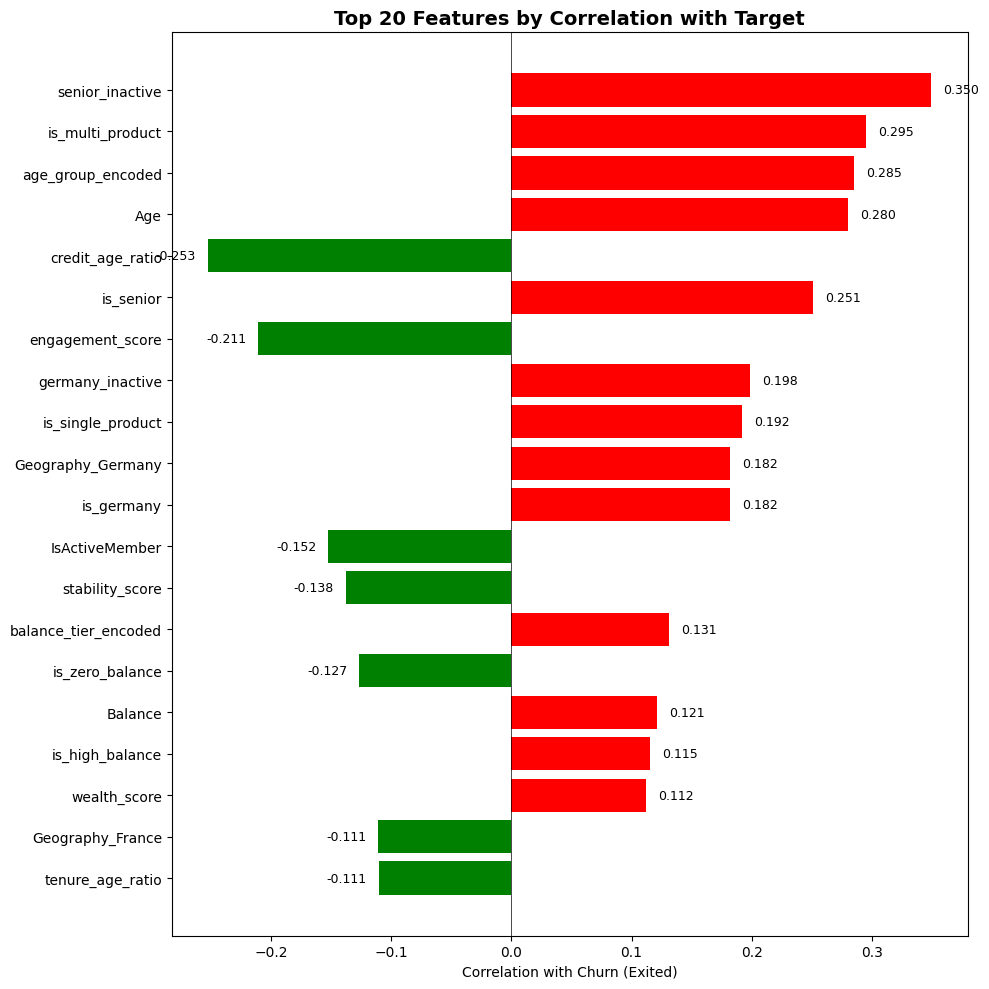

All Feature Correlations with Target:
🔴 senior_inactive                    : +0.3496
🔴 is_multi_product                   : +0.2950
🔴 age_group_encoded                  : +0.2853
🔴 Age                                : +0.2804
🟢 credit_age_ratio                   : -0.2525
🔴 is_senior                          : +0.2507
🟢 engagement_score                   : -0.2109
🔴 germany_inactive                   : +0.1984
🔴 is_single_product                  : +0.1922
🔴 Geography_Germany                  : +0.1822
🔴 is_germany                         : +0.1822
🟢 IsActiveMember                     : -0.1523
🟢 stability_score                    : -0.1381
🔴 balance_tier_encoded               : +0.1310
🟢 is_zero_balance                    : -0.1266
🔴 Balance                            : +0.1214
🔴 is_high_balance                    : +0.1153
🔴 wealth_score                       : +0.1120
🟢 Geography_France                   : -0.1108
🟢 tenure_age_ratio                   : -0.1106
🔴 Gender_Female       

In [51]:
# Calculate correlation with target for all numeric features (exclude string/object columns)
train_with_target = X_train_scaled.copy()
train_with_target['Exited'] = y_train.values

# Only keep numeric columns for correlation calculation
numeric_cols = train_with_target.select_dtypes(include=['int64', 'float64', 'bool']).columns
correlations = train_with_target[numeric_cols].corr()['Exited'].drop('Exited').sort_values(key=abs, ascending=False)

# Visualize top 20 correlations
plt.figure(figsize=(10, 10))
top_corrs = correlations.head(20)
colors = ['red' if x > 0 else 'green' for x in top_corrs.values]
bars = plt.barh(range(len(top_corrs)), top_corrs.values, color=colors)
plt.yticks(range(len(top_corrs)), top_corrs.index)
plt.xlabel('Correlation with Churn (Exited)')
plt.title('Top 20 Features by Correlation with Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Add correlation values
for i, (bar, val) in enumerate(zip(bars, top_corrs.values)):
    plt.text(val + 0.01 if val > 0 else val - 0.01, i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right', fontsize=9)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Print all correlations
print("All Feature Correlations with Target:")
print("=" * 50)
for feat, corr in correlations.items():
    indicator = "🔴" if corr > 0.05 else "🟢" if corr < -0.05 else "⚪"
    print(f"{indicator} {feat:35s}: {corr:+.4f}")

## 8. Save Processed Data

In [52]:
# Save processed datasets
# 1. Scaled data for modeling
X_train_scaled.to_csv(PROCESSED_PATH / 'X_train_scaled.csv', index=False)
X_test_scaled.to_csv(PROCESSED_PATH / 'X_test_scaled.csv', index=False)
y_train.to_csv(PROCESSED_PATH / 'y_train.csv', index=False)
y_test.to_csv(PROCESSED_PATH / 'y_test.csv', index=False)

# 2. Unscaled data (for tree-based models that don't need scaling)
X_train.to_csv(PROCESSED_PATH / 'X_train.csv', index=False)
X_test.to_csv(PROCESSED_PATH / 'X_test.csv', index=False)

# 3. Save scaler for deployment
joblib.dump(scaler, PROCESSED_PATH / 'scaler.pkl')

# 4. Save feature lists
feature_config = {
    'all_features': list(X_train.columns),
    'cols_to_scale': COLS_TO_SCALE,
    'binary_cols': binary_pattern_cols,
    'ordinal_mappings': ORDINAL_MAPPINGS
}
joblib.dump(feature_config, PROCESSED_PATH / 'feature_config.pkl')

print("Saved processed data to:", PROCESSED_PATH)

Saved processed data to: ../data/processed


## Summary

1. **Strongest positive correlations** (increase churn):
   - `senior_inactive` - Inactive members aging of 50+ churn more
   - `is_multi_product` - Members with more product churn more

2. **Strongest negative correlations** (decrease churn):
   - `credit_age_ratio` - high credit/young members stay
   - `engagement_score` - Engaged customers stay